Parsed with column specification:
cols(
  .default = col_double(),
  numsampled = col_integer()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  Sample_ID = col_character(),
  Treatment = col_character()
)
Warning message:
“Column `Sample_ID` joining character vector and factor, coercing into character vector”

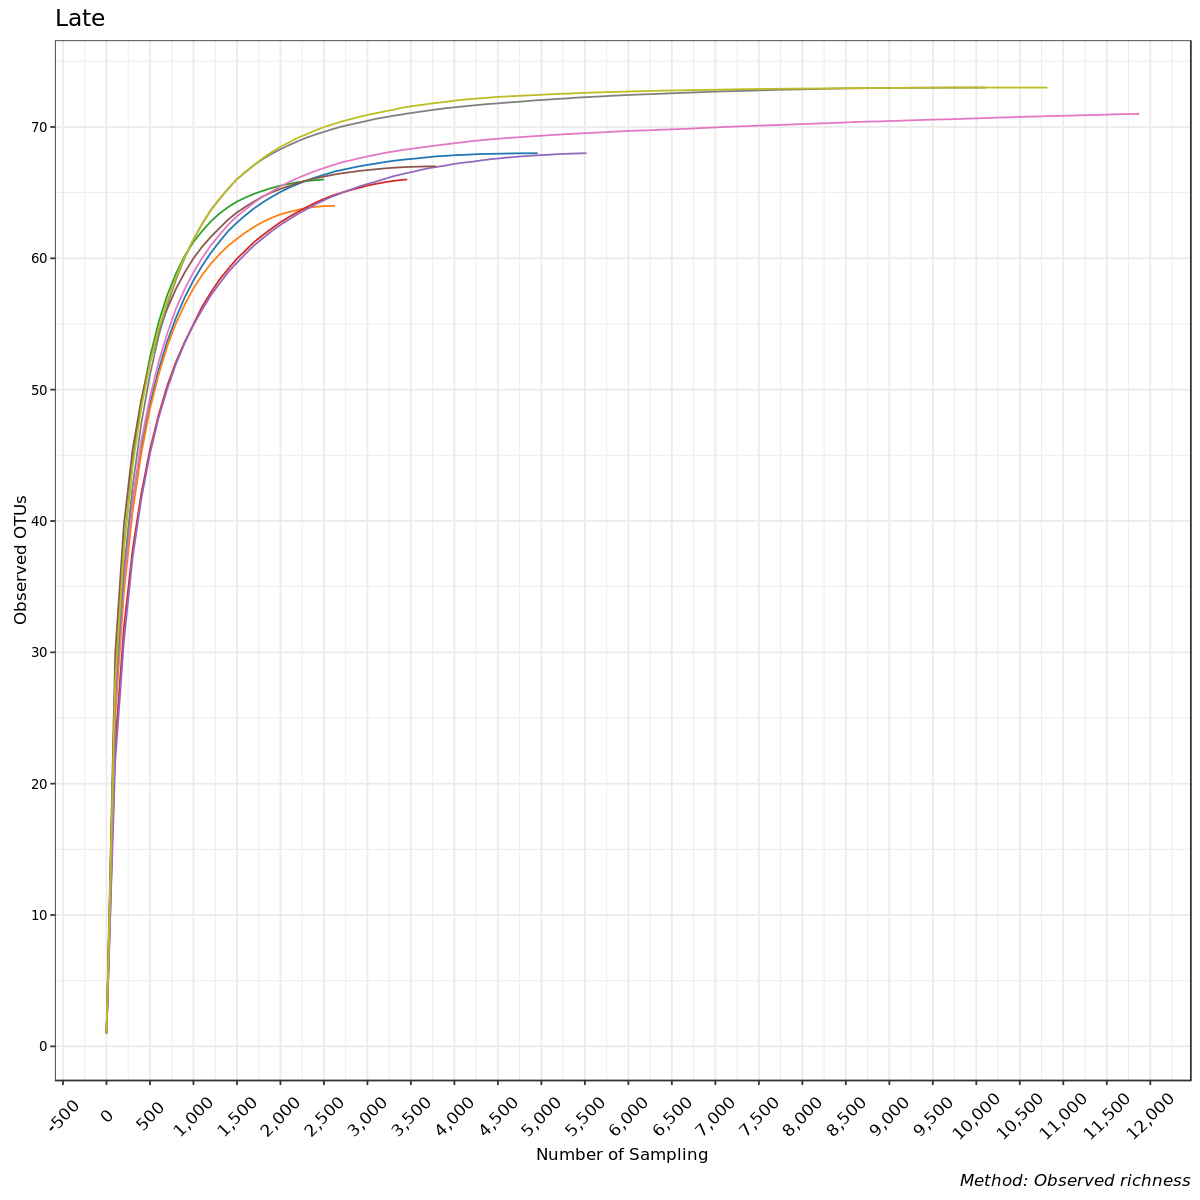

In [50]:
#####################
# Data Loading
#####################
library(tidyverse)
library(ggplot2)
library(reshape2)
library(cowplot)
library(tools)
######################
#SETTING
args = commandArgs(trailingOnly=TRUE)
options(scipen=10000000)
Default_Color = c('#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf')
theme_set(theme_bw(base_family = "Sans"))
OFFLINE_MODE=FALSE
if(OFFLINE_MODE==FALSE){
options(repr.plot.width=10, repr.plot.height=10)
}
######################
#INPUT/OUTPUT
if(OFFLINE_MODE==FALSE){
    rarefaction_file_Path = "/data/shamsaddinisha/MBAC/MOTHUR/MISEQ_SOP/MISEQ_SOP_SMALL/Late/overview/Late.overview.rarefaction.txt"
    metadata_file_Path = "/data/shamsaddinisha/MBAC/MOTHUR/MISEQ_SOP/MISEQ_SOP_SMALL/Late/overview/Late_mothur_metadata.txt"
    rarefaction_plot_output = "./Late.overview.rarefaction.txt"
}else{
    rarefaction_file_Path = args[1]
    metadata_file_Path = args[2]
    rarefaction_plot_output = args[3]
}
#####################
#READ I/O
rarefaction_DF = read_tsv(rarefaction_file_Path)
#head(rarefaction_DF)
#dim(rarefaction_DF)
metadata_DF = read_tsv(metadata_file_Path)
#head(metadata_DF)
#dim(metadata_DF)
####################
#Data Wrangling
relabeled_rarefaction_DF = rarefaction_DF[,-grep(pattern="^lci|^hci",colnames(rarefaction_DF))]
col_old <- colnames(relabeled_rarefaction_DF)
col_new <- gsub(pattern = ".*-",replacement = "", x  = col_old)
colnames(relabeled_rarefaction_DF) <- col_new
#
#head(relabeled_rarefaction_DF)
melted_relabeled_rarefaction_DF = melt(relabeled_rarefaction_DF, id.vars = c("numsampled"), variable.name = "Sample_ID", value.name="Rarefaction_Value") %>%
    filter(Rarefaction_Value != "NA")
#
metadata_melted_relabeled_rarefaction_DF = metadata_DF %>%
    left_join(melted_relabeled_rarefaction_DF, by = c("Sample_ID" = "Sample_ID"))
#head(metadata_melted_relabeled_rarefaction_DF, 100)

#
design_List = sort(unique(metadata_DF$Treatment))
design_list_Length = length(design_List)
#
filterd_metadata_melted_relabeled_rarefaction_DF = metadata_melted_relabeled_rarefaction_DF %>%
    filter(Treatment == design_List[[1]])
#head(filterd_metadata_melted_relabeled_rarefaction_DF, 100)

#
sample_count = length(unique(filterd_metadata_melted_relabeled_rarefaction_DF$Sample_ID))
    if(sample_count <= 20){
        sample_count_limit = sample_count 
    }else{
        sample_count_limit = 20
    }

unmelted_filtered_metadata_melted_relabeled_rarefaction_DF = filterd_metadata_melted_relabeled_rarefaction_DF %>%
    spread(Sample_ID, Rarefaction_Value) %>%
    select(-Treatment)
#head(unmelted_filtered_metadata_melted_relabeled_rarefaction_DF)
#
melted_unmelted_filtered_metadata_melted_relabeled_rarefaction_DF = unmelted_filtered_metadata_melted_relabeled_rarefaction_DF %>%
        select(1:sample_count_limit) %>%
        melt(id.vars = c("numsampled"), variable.name = "Sample_ID", value.name="Rarefaction_Value", na.rm = TRUE)
#head(melted_unmelted_filtered_metadata_melted_relabeled_rarefaction_DF)
#####################
#Data Plotting
ggplot_Object = ggplot(data = melted_unmelted_filtered_metadata_melted_relabeled_rarefaction_DF, aes(x = numsampled, y = Rarefaction_Value, color = Sample_ID)) +
    geom_line(position = "identity") +
    scale_color_manual(values = colorRampPalette(Default_Color)(sample_count)) +
    scale_y_continuous(labels = scales::comma, breaks = scales::pretty_breaks(n = 10)) +
    scale_x_continuous(labels = scales::comma, breaks = scales::pretty_breaks(n = 20)) +
    labs(title = design_List[[1]], caption = "Method: Observed richness", subtitle = NULL, tag = NULL, x="Number of Sampling", y="Observed OTUs") +
    theme(
        text=element_text(family="Sans"),
        plot.title = element_text(size=14, color = "black", face = "plain" ),
        plot.subtitle = element_text(size=12, color = "black", face = "plain" ),
        plot.caption = element_text(size=10, color = "black", face = "italic"),
        #Axis
        axis.title.x = element_text(size=10,  family="sans", face="plain", color = "black", hjust = 0.5),
        axis.title.y = element_text(size=10,  family="sans", face="plain", color = "black", hjust = 0.5, vjust=0),
        axis.text.x = element_text(size=10,  family="sans", face="plain", color = "black", angle=45, vjust=0.5),
        axis.text.y = element_text(size=8,  family="sans", face="plain", color = "black", angle=0, vjust=0.5),
        #LEGEND
        legend.position="none",
    )
if(OFFLINE_MODE==FALSE){
ggplot_Object
}
if(OFFLINE_MODE==TRUE){

#####################
#EXPORTING
file_extension = file_ext(rarefaction_plot_output)
#
plot_PDF = gsub(file_extension, "plot.pdf", rarefaction_plot_output)
plot_PNG = gsub(".pdf", ".png", plot_PDF)
plot_JPG = gsub(".pdf", ".jpg", plot_PDF)
plot_SVG = gsub(".pdf", ".svg", plot_PDF)
plot_TXT = gsub(".pdf", ".txt", plot_PDF)
#
ggsave(file=plot_PDF, device=cairo_pdf, plot=ggplot_Object, width=15, height =5, units = "in", limitsize = FALSE, dpi=1200)
ggsave(file=plot_PNG, device="png", plot=ggplot_Object, width=15, height =5, units = "in", limitsize = FALSE, dpi=300)
ggsave(file=plot_JPG, device="jpg", plot=ggplot_Object, width=15, height =5, units = "in", limitsize = FALSE, dpi=300)
ggsave(file=plot_SVG, device="svg", plot=ggplot_Object, width=15, height =5, units = "in", limitsize = FALSE, dpi=72)
write_tsv(path=plot_TXT, x=unmelted_filtered_metadata_melted_relabeled_rarefaction_DF)
print("Rarefaction completed Successfully!!!")
}